# Run cells from AllenDB

In [1]:
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

#choose specimen id and model type

In [2]:
# Mouse L2/3 PV cell
# https://celltypes.brain-map.org/experiment/electrophysiology/484635029
specimen_id = 484635029

model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [3]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

# If error, restart env

/home/hrbncv/miniconda3/envs/BMTK/lib/python3.9/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [4]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

#Download the cell -  if using HOC: upload the hoc template to the working directory and modfiles into a folder named 'modfiles' and skip to 'Build the Cell' then 'Simulation Parameters'

#Also if using hoc, double check parameters every time build_cell() is used

In [5]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 485602029



[{'id': 485602029,
  'name': 'Biophysical - perisomatic_Pvalb-IRES-Cre;Ai14-201791.05.01.01',
  'neuron_reconstruction_id': 496079599,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 484635029},
 {'id': 496538965,
  'name': 'Biophysical - all active_Pvalb-IRES-Cre;Ai14-201791.05.01.01',
  'neuron_reconstruction_id': 496079599,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 484635029}]

## Build the cell

if you need additonal modfiles from a public repo, provide a list of the names of the modfiles and a link to the folder

In [6]:
# Compile the modfiles
os.chdir(work_dir)
!nrnivmodl modfiles > /dev/null 2>&1

In [7]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

**NOTE:** Control the soma area in the `build_cell` function below.

In [8]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

def set_simulation(hoc_object,sim_params, soma_diam_multiplier = 1.0):
    from neuron import h
    h.load_file("stdrun.hoc")
    stim = h.IClamp(hoc_object.soma[0](0.5))
    stim.amp = sim_params['stim_amp']
    stim.delay = sim_params['stim_delay']
    stim.dur = sim_params['stim_dur']
    h.tstop = sim_params['h_tstop']
    h.dt = sim_params['h_dt']
    # h.steps_per_ms = 1 / h.dt
    return h, stim

In [ ]:

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)

--No graphics will be displayed.


#Morphology

In [10]:
print(f"Soma area: {hobject.soma[0](0.5).area()}")
print(f"Soma diam: {hobject.soma[0].diam}")
print(f"Soma L: {hobject.soma[0].L}")

Soma area: 669.646002883916
Soma diam: 14.599800109863281
Soma L: 14.599853515625


## Passive properties

In [ ]:
# Soma area from the previous cell
computed_soma_area = hobject.soma[0](0.5).area() * 1e-8 #(cm2)
# User-provided desired properties
user_provided_Rin = 98.9 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 5.9 * 1e-3 # (to s from ms)
user_provided_Vrest = -71.25 # (mV)
spps = ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)
print(spps)

SettablePassiveProperties(Cm=0.8908620098605767, g_bar_leak=0.00015099356099331808, e_rev_leak=-71.25, g_bar_h=None)


#set simulation parameters

In [23]:
sim_params = {
                'stim_amp': -0.1,
                'stim_delay': 300,
                'stim_dur': 1000,
                'h_tstop': 1500,
                'h_dt': 0.025
                }


#run the simulation

In [15]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [16]:
#function to get the start and end index of the stim but in the voltage file
def get_start_end_idx(sim_params):
  start_idx = int(sim_params['stim_delay']/sim_params['h_dt'])
  end_idx = int(sim_params['stim_dur']/sim_params['h_dt'])
  return start_idx, end_idx

In [17]:
#function to calculate the frequency of a voltage trace
def get_frequency(v,sim_params):

  start_idx,end_idx = get_start_end_idx(sim_params)
  spikes = count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx])

  if spikes> 0:
    duration_sec = sim_params['stim_dur'] / 1000.0
    freq = spikes / duration_sec
    return freq

  else:
    return 0

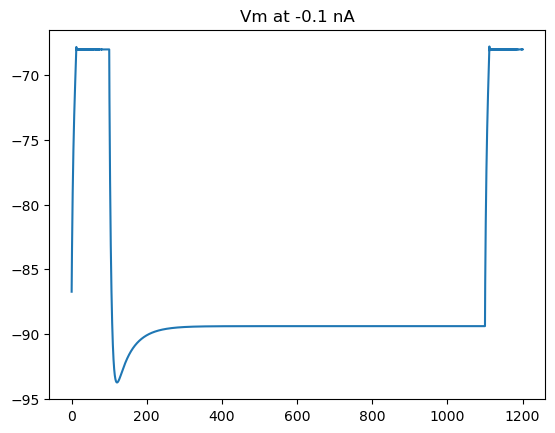

spike frequency = 0.00 Hz


In [18]:
#modify simulation parameters if needed
sim_params['stim_amp'] = -0.1

#rebuild the cell to make sure the set_simulation() is using the correct hobj
#if using hoc call with the hoc filename and cell name

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

# run the simulation
h, stim = set_simulation(hobject,sim_params)
v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.finitialize()
h.run()

#plot the result and display spike frequency
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(T,V)
plt.title(f"Vm at {sim_params['stim_amp']} nA")
plt.show()

print(f"spike frequency = {get_frequency(v,sim_params):.2f} Hz")

In [ ]:
#find Rin, tau, sag ratio, and Vrest

print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, sim_params['stim_delay'], 1290, sim_params['stim_amp']))
print(f"V-rest: {v.as_numpy()[sim_params['stim_dur']]}")

V = v.as_numpy()
stim_start = int(sim_params['stim_delay']/h.dt)
stim_dur = int(sim_params['stim_dur']/h.dt)
stead_state_v = V[stim_start+stim_dur-10]
end_of_sag = int(stim_start + stim_dur*0.2)
minimum_v = np.min(V[stim_start:stim_start + end_of_sag])
sag_ratio = stead_state_v / minimum_v
print(f"Sag ratio: {sag_ratio}")

GettablePassiveProperties(R_in=257.5109423114462, tau1=4.7, tau2=983.0, sag_ratio=1.0000487880677082, V_rest=-68.00035945647915)
V-rest: -68.00786674607869


## FI-Curve

In [20]:
#test the cell at multiple frequencies to get an FI curve

frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


for amp in amps:
  #if using hoc call with the hoc filename and cell name
    hobject = build_cell(soma_diam_multiplier)
    #hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

    sim_params['stim_amp'] = amp
    h, stim = set_simulation(hobject,sim_params)
    v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(get_frequency(v,sim_params))


In [21]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 0
0.1: 0
0.15: 0
0.2: 1.0
0.25: 1.0
0.3: 29.0


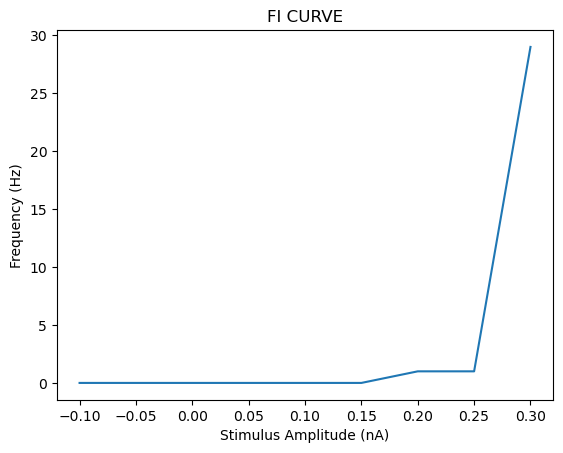

In [22]:

plt.plot(amps, frequenies)
plt.title("FI CURVE")
plt.xlabel("Stimulus Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.show()